# Assignment - 1
# Computer Vision (Camera Calibration)
<br><br>
Parth Partani<br>
20161034

In [1]:
# Import libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
%matplotlib inline

Found coordinates of points in the image using matplotlib library. These coordinates can also be found using Harris Corner Detector, but in this case was not efficient. Given coordinates are for all 36 points in the image.

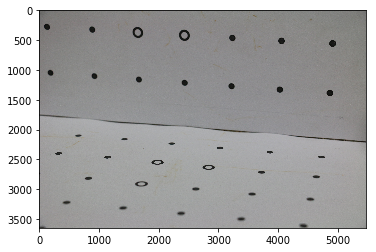

In [2]:
im = mpimg.imread('./Assignment1_Data/IMG_5455.JPG')
plt.imshow(im)

plt.show()

image_points  = [[140,285],[908,338],[1655,391],[2450,431],[3223,465],[4070,535],
               [4945,552],[200,1045],[941,1112],[1682,1159],[2456,1232],[3243,1265],
               [4064,1326],[4878,1392],[661,2100],[1435,2166],[2222,2233],[3043,2306],
               [3877,2380],[4744,2460],[334,2400],[1148,2460],[1995,2547],[2849,2627],
               [3737,2713],[4658,2794],[834,2807],[1722,2907],[2629,2987],[3570,3080],
               [4551,3167],[474,3214],[1408,3314],[2389,3401],[3377,3488],[4437,3614]]
image_points = np.array(image_points)
points = image_points.shape[0]

Now we need to find world coordinates in order to find camera matrix and for further use.<br>
* Difference of X coordinate for any 2 point in 36 so X coordinate for any given point will be multipe of 36 and therefore it is given be linspace.
* On X-Y plane there are 2 rows for 7 points therefore Y coordinates(world) will contain 7 points with 72 and 36 each and rest will we 0.
* There 2 rows with 6 points and 5 points each on X-Z place and for each row distance keeps increasing by 36 i.e.36, 72, 108, 144.

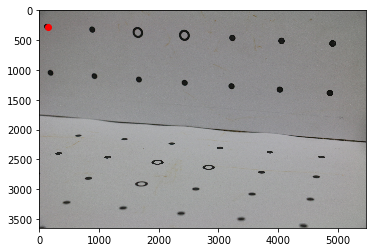

Point Coordinates
Image Point : [140 285] , World Point : [ 216.   72.    0.]


In [46]:
im1 = mpimg.imread('./Assignment1_Data/IMG_5455.JPG')
plt.imshow(im1)

plt.plot(image_points[0,0],image_points[0,1],'ro')
plt.show()

X = np.array([np.linspace(216,0,7), np.linspace(216,0,7),np.linspace(180,0,6),
              np.linspace(180,0,6),np.linspace(144,0,5),np.linspace(144,0,5)])
XW, YW, ZW = [],[],[]
for i in range(len(X)):
    for j in range(len(X[i])):
        XW.append(X[i][j])

YW = [72]*7 + [36]*7 + [0]*22
ZW = [0]*14 + [36]*6 + [72]*6 + [108]*5 + [144]*5

world_points = []
for i in range(points):
    world_points.append([XW[i],YW[i],ZW[i]])
world_points = np.array(world_points)
print("Point Coordinates")
print("Image Point : " + str(image_points[0]) + " , World Point : " + str(world_points[0]))

## Ques 1 Direct Linear Transformation :
It is used to find projection matrix.<br>

x = PX 
(P is Projection Matrix, X is Homogeneous World Points, x is Homogeneous Image Points)
is  rearranged such that it changes to AP1 = 0 where A is computed from world points and Image Points. P1 is the flattened P matrix. A is of the form 2n X 12 where n is number of image points.

Next SVD of A gives U,D,VT where the last column of V gives the projection matrix so that least eigenvalue is picked. Reshaping this to 3X4 form gives us the projection matrix. It is then Normalized to make P[3,4] = 1

Further QR decomposition of obtained P matrix gives us the Camera Matrix (K) and Rotation Matrix(R). This is then used to find the Camera Projection Matrix(T).


Here a matrix is defined whose rows are:<br>
(-X(i), -Y(i), -Z(i), -1, 0, 0, 0, 0, x(i)X(i), y(i)Y(i), z(i)Z(i), x(i)) (even rows)<br>
( 0, 0, 0, 0, -X(i), -Y(i), -Z(i), -1, x(i)X(i), y(i)Y(i), y(i)Z(i), y(i)) (odds rows)<br>
and then SVD is used to find a (3x4) projection matrix.

In [4]:
def dlt(world,image):
    pt = world.shape[0]
    mat =  np.zeros((2*pt,12))
    for i in range(pt):
        # even positions
        mat[i*2][:3] = -world[i][:]
        mat[i*2][3] = -1
        mat[i*2][8:11] = image[i][0]*world[i][:]
        mat[i*2][11] = image[i][0]
        
        
        
        # odd positions
        mat[i*2+1][4:7] = -world[i][:]
        mat[i*2+1][7] = -1
        mat[i*2+1][8:11] = image[i][1]*world[i][:]
        mat[i*2+1][11] = image[i][1]
    
    # Use last row for projection matrix
    U, D, V = np.linalg.svd(mat)
    proj = V[11]
    proj = np.reshape(proj,(3,4))
    proj = proj/proj[2][3]
    return proj

In [5]:
PROJ_DLT = dlt(world_points, image_points)
print("Projection Matrix")
print(PROJ_DLT)

Projection Matrix
[[ -2.11225340e+01  -1.52511970e+00  -9.72155998e+00   4.82458631e+03]
 [ -1.09832879e+00  -2.24096507e+01   4.43993421e+00   2.15758505e+03]
 [  3.60153741e-04  -6.15323259e-04  -1.57382436e-03   1.00000000e+00]]


### Camera Calibration
Using projection matrix to find camera matrix(K, R, T) which defines a relation between image points and world points.<br>
![alt text](./Assignment1_Data/cam.png "Equation")

In [6]:
def camera_mat(pr):
    x1 = pr[:,:3]
    print(x1.shape)
    x2 = pr[:,3]
    T = -np.matmul(np.linalg.inv(x1),x2)
    
    x1 = np.linalg.inv(x1)
    R,K = np.linalg.qr(x1)
    R = np.linalg.inv(R)
    K = np.linalg.inv(K)
    K = K/K[2,2]
    return K,R,T

In [7]:
KRT = camera_mat(PROJ_DLT)
print("K = ",KRT[0])
print("\nR = ",KRT[1])
print("\nT = ",KRT[2])

(3, 3)
K =  [[ -1.31727418e+04   1.10459424e+02   2.89124562e+03]
 [ -0.00000000e+00  -1.30624295e+04   2.14585760e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

R =  [[-0.9745131   0.00332142 -0.22430602]
 [-0.08290827 -0.93442929  0.34636416]
 [-0.2084477   0.35613323  0.91088895]]

T =  [ -37.81612913  206.32412615  546.0738609 ]


Reproducing Image Points using Projection Matrix and WorldPoints
[ImagePoints] = [Projection Matrix] * [WorldPoints].T

In [8]:
# generates points using Projection matrix
def reproduce(proj,world):
    pts = world.shape[0]
    World = np.ones((pts,4))
    World[:,:3] = world[:,:]

    f_points = np.zeros((pts,3))
    for i in range(pts):
        f_points[i,:] = np.matmul(proj,World[i,:].T)
        f_points[i,:] /=  f_points[i,2]
    f_points = np.int_(f_points[:,:2])
    return f_points

DLT Generated Image Points :
[[ 147  894 1660 2446 3253 4082 4933  196  928 1678 2447 3236 4046 4877
   667 1439 2233 3047 3883 4743  339 1153 1991 2853 3739 4651  831 1718
  2633 3575 4547  464 1407 2381 3388 4428]
 [ 296  339  383  427  473  520  569 1054 1105 1158 1211 1266 1323 1381
  2102 2169 2238 2309 2381 2456 2395 2470 2548 2627 2709 2793 2810 2898
  2988 3081 3177 3197 3297 3400 3506 3616]]


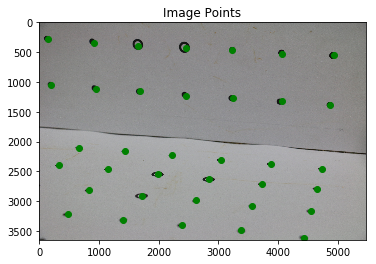

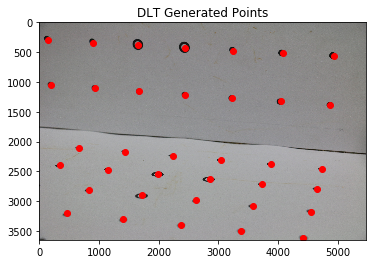

In [9]:
dlt_points = reproduce(PROJ_DLT, world_points)
print("DLT Generated Image Points :")
print(dlt_points.T)

plt.title("Image Points")
plt.imshow(im)
plt.plot(image_points[:,0],image_points[:,1],'go')
plt.show()

plt.title("DLT Generated Points")
plt.imshow(im)
plt.plot(dlt_points[:,0],dlt_points[:,1],'ro')
plt.show()

## Ques : 2 RANSAC
RANSAC (RANdom SAmpling Consensus) is a resampling technique which is used to find the best possible minimum candidates  required for finding P matrix by using only 6 points to find P matrix and then finding number of points which are under a threshold for the reprojected points and image points.
This process is repeated for N  = 2000 number of times and then the best P matrix is used for finding R and T.
<br>
<br>
<br>
Out for 36 points take any 6 points to generate Projection matrix using DLT. Then using matrix multiplication for Projection matrix and World Points to generate Image Points and finding error also keeping in mind that 6 points should not be coplanar.<br>


Here 2 hyperparameters are used :
* theta = Threshold
* N = Number of iterations

In [10]:
# calculates error and finds outliers using manhattan distance
def dist(a,b):
    return np.abs(a[0]-b[0]) + np.abs(a[1]-b[1])

def error(proj, world, image):
    theta = 1.5
    pts = image.shape[0]
    W = np.ones((pts,4))
    W[:,:3] = world[:,:]
    count = 0
    for i in range(pts):
        ppoints = np.matmul(proj,W[i,:].T)
        ppoints /= ppoints[2]
        if dist(ppoints[:2],image[i]) < theta:
            count += 1
    return count

In [11]:
def ransac(image, world):
    N = 100
    pts = image.shape[0]
    image_pts = np.zeros((pts-6,2))
    world_pts = np.zeros((pts-6,3))
    proj_imps = np.zeros((6,2))
    proj_wrps = np.zeros((6,3))
    best_proj = []
    inliers_max = 0
    for i in range(N):
        rand_pt  = random.sample(range(pts),6)
        # print(rand_pt)
        p = 0
        q = 0
        for j in range(pts):
            if j in rand_pt:
                proj_imps[q,:] = image[j,:]
                proj_wrps[q,:] = world[j,:]
                q += 1
            else:    
                image_pts[p,:] = image[j,:]
                world_pts[p,:] = world[j,:]
                p += 1
        if(((np.sum(proj_wrps,axis=1))[1] == 0) or ((np.sum(proj_wrps,axis=1))[2] == 0)): continue
        proj = dlt(proj_wrps,proj_imps)
        inliers = error(proj, world_pts, image_pts)
        
        if (inliers_max < inliers):
            best_proj = proj
            inliers_max = inliers
            print("Iner : " + str(i) + " , Max Inliers : " + str(inliers_max))
    return best_proj

## Ques : 3
Generating Image Points using RANSAC and DLT

In [12]:
PROJ_RANSAC = ransac(image_points, world_points)
print("Projection matrix RANSAC")
print(PROJ_RANSAC)
RANSAC_points = reproduce(PROJ_RANSAC, world_points)
# print(RANSAC_points.T)

Iner : 32 , Max Inliers : 1
Projection matrix RANSAC
[[ -2.13082760e+01  -4.46768336e-01  -9.54844049e+00   4.81305597e+03]
 [ -1.16095574e+00  -2.18516802e+01   4.55852004e+00   2.14393958e+03]
 [  2.99125975e-04  -4.28304648e-04  -1.56273313e-03   1.00000000e+00]]


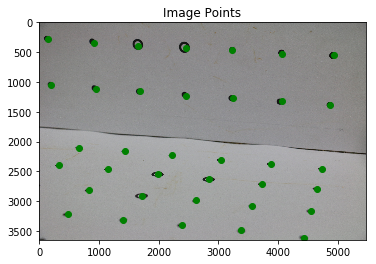

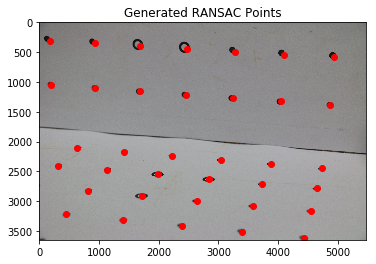

In [13]:
plt.title("Image Points")
plt.imshow(im)
plt.plot(image_points[:,0],image_points[:,1],'go')
plt.show()

plt.title("Generated RANSAC Points")
plt.imshow(im)
plt.plot(RANSAC_points[:,0],RANSAC_points[:,1],'ro')
plt.show()

## Ques : 4 Radial Distortion
Radial Distortion is corrected and the plot shows the original and distorted image.

### Distortion Parameters are:
[[ 6.90747433e-01 -7.92332549e+00  1.20551292e-02  6.50107752e-02
   4.30052966e+01]]


(3, 3)
Distortion Parameters are:
[[  6.90743293e-01  -7.92326310e+00   1.20551275e-02   6.50106730e-02
    4.30049428e+01]]


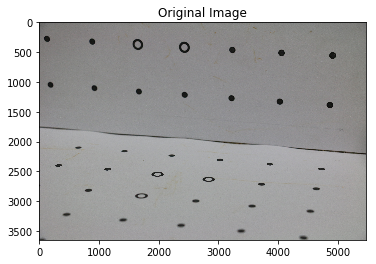

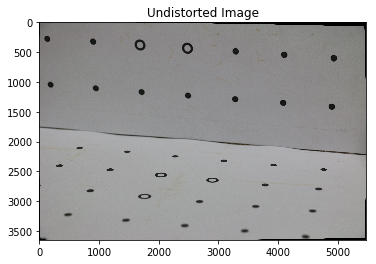

In [15]:
KRT_RANSAC = camera_mat(PROJ_RANSAC)
I_gray =cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
temp = [[-1,0,0],[0,-1,0],[0,0,1]]
K_positive = np.matmul(KRT_RANSAC[0],temp)
K_positive[0,1] = 0

world_pts1 = world_points[:,:3]
image_pts1 = image_points[:,:2]
world_pts1 = world_pts1.astype('float32')
image_pts1 = image_pts1.astype('float32')
ret, K_temp, dist1, rvecs, tvecs = cv2.calibrateCamera([world_pts1],[image_pts1],I_gray.shape[::-1],
                                    K_positive,None,None,flags = (cv2.CALIB_USE_INTRINSIC_GUESS))

h, w = im.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(K_temp,dist1,(w,h),1,(w,h))

print('Distortion Parameters are:')
print(dist1)
I_undistort = cv2.undistort(im,K_temp,dist1,None,newcameramtx)
# plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Original Image')
plt.show()
# plt.subplot(1,2,2)
plt.imshow(I_undistort)
plt.title('Undistorted Image')
plt.show()

Since the distortions observed are very small, hence the observed results after distortions are very close to observed results.

## Ques : 5 Wire Frame
Creating wireframe of the object using the points generated from RANSAC

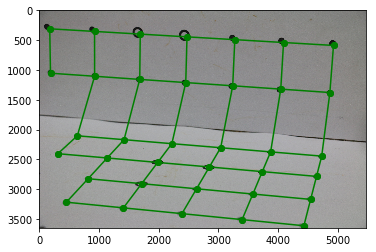

In [48]:
arx = [7, 7, 6, 6, 5, 5]
v = 0
plt.imshow(im)
for i in range(len(arx)):
    plt.plot(RANSAC_points[v:v+arx[i],0],RANSAC_points[v:v+arx[i],1],'go-')
    v += arx[i]
    
ary = [2, 4, 6, 6, 6, 6, 6]
val = [0, 7, 13, 19, 24, 29]
for i in reversed(range(len(ary))):
    plt.plot([RANSAC_points[i+val[j],0] for j in range(ary[i])],
             [RANSAC_points[i+val[j],1] for j in range(ary[i])],'go-')

## Ques : 6 Camera Calibration using Zhangs Method

It imports multiple images and returns a list.<br>
For the implementation of Zhang’s Method a 8X6 checkerboard is used and an inbuilt OpenCV implementation is used.

In [17]:
def imageImport(inipath,number,ext):
    images = []
    for i in range(number[0]):
        c = cv2.imread(inipath + str(number[1]+i) + ext)
        images.append(c)
    return images

It uses an in-built function "cv2.findChessboardCorners" to find corners in the chessboard and takes input as shape of the grid.

In [18]:
def findCorners(path,shape):
    chess = cv2.imread(path)
    plt.imshow(chess)
    plt.title("Corners using in-built function")
    ret, corners = cv2.findChessboardCorners(chess,(shape[0],shape[1]))
    image_chess = corners.reshape(-1,2)
    x, y = np.meshgrid(range(shape[0]),range(shape[1]))
    chess_coord = np.hstack((x.reshape(shape[0]*shape[1],1),y.reshape(shape[0]*shape[1],1),
                             np.zeros((shape[0]*shape[1],1)))).astype(np.float32)
    plt.plot(corners[:,0,0],corners[:,0,1],'go')
    plt.show()
    return chess_coord

In [49]:
def zhangs(chess_coord1,images,shape):
    im_coord, w_coord = [],[]
    n = len(images)
    
    for i in range(n):
        ret,corners = cv2.findChessboardCorners(images[i],(shape[0],shape[1]))
        print("Image : " + str(i) + " , ChessBoardFound : " + str(ret))
        if ret:
            im_coord.append(corners)
            w_coord.append(chess_coord1)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(w_coord,im_coord,
                                (images[n-1].shape[1],images[n-1].shape[0]), None, None)
    return mtx, rvecs, tvecs

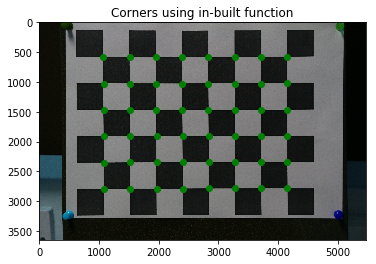

Image : 0 , ChessBoardFound : True
Image : 1 , ChessBoardFound : True
Image : 2 , ChessBoardFound : True
Image : 3 , ChessBoardFound : True
Image : 4 , ChessBoardFound : True
Image : 5 , ChessBoardFound : True
Image : 6 , ChessBoardFound : True
Image : 7 , ChessBoardFound : True
Image : 8 , ChessBoardFound : True
Image : 9 , ChessBoardFound : True
Image : 10 , ChessBoardFound : True
Image : 11 , ChessBoardFound : True
Image : 12 , ChessBoardFound : True
Image : 13 , ChessBoardFound : True
Camera Calibration Matrix
[[  1.35997371e+04   0.00000000e+00   3.36312443e+03]
 [  0.00000000e+00   1.36159997e+04   1.48643588e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [20]:
world_chess = findCorners('./Assignment1_Data/IMG_5456.JPG',[8,6])
chess_images = imageImport('./Assignment1_Data/IMG_',[14,5456],'.JPG')
chess_mat = zhangs(world_chess,chess_images,[8,6])
print("Camera Calibration Matrix")
print(chess_mat[0])

### Ploting points generated using camera calibration matrix

In [21]:
def plot_points(mat1, image, world_coord,no):
    nn = world_coord.shape[0]
    ww = np.zeros((nn,4))
    ww[:,:2] = world_coord[:,:2]
    ww[:,2] = 0
    ww[:,3] = 1
    
    rotation_mat = np.zeros((3,3))
    R = cv2.Rodrigues(mat1[1][no], rotation_mat)[0]
    P = np.column_stack((np.matmul(mat1[0],R), np.matmul(mat1[0], mat1[2][no])))
    P = P/P[2,3]

    projected_point = np.zeros((nn, 3))

    for i in range(nn):
        projected_point[i,:] = np.matmul(P, ww[i,:])
        projected_point[i,:] = projected_point[i,:] / projected_point[i,2]

    plt.imshow(image[no])
    plt.title("Projected points using Zhangs Method")
    plt.plot(projected_point[:,0],projected_point[:,1],'go')
    plt.show()
    return projected_point

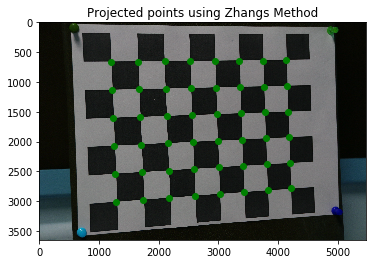

In [22]:
chess_points = plot_points(chess_mat,chess_images,world_chess,2)

## Ques : 7 Wireframe for generated points on chess board

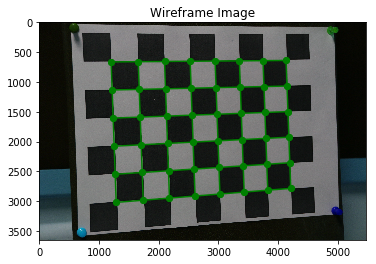

In [23]:
plt.imshow(chess_images[2])
plt.title("Wireframe Image")
for i in range(6):
    plt.plot(chess_points[i*8:i*8+8,0],chess_points[i*8:i*8+8,1],'go-')

for i in range(8):
    plt.plot([chess_points[j*8+i,0] for j in range(6)],[chess_points[j*8+i,1] for j in range(6)],'go-')
plt.show()

## Ques : 8 Image of world orign
Image of the world origin should be the projection centre of the image.

Image Coordinates of Orign  [  4.82458631e+03   2.15758505e+03   1.00000000e+00]


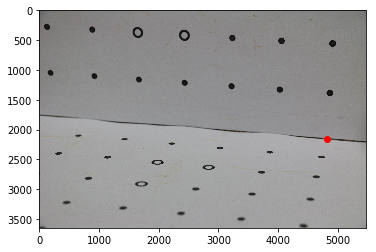

In [51]:
plt.imshow(im)
orign_W = [0,0,0,1]
orign_I = np.matmul(PROJ_DLT,orign_W)
orign_I /=  orign_I[2]
print("Image Coordinates of Orign ",orign_I)
plt.plot(orign_I[0],orign_I[1],'ro')
plt.show()


## Ques : 9 Import images from personal camera
* Chess Board Image

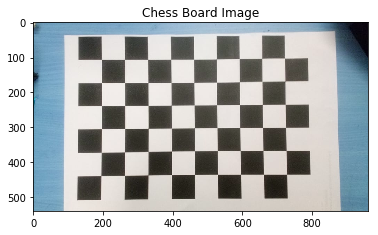

Image Point Coordinates
[[ 195.7485199   440.00042725]
 [ 196.9145813   372.17645264]
 [ 196.98423767  305.68569946]
 [ 197.4903717   239.64387512]
 [ 197.59515381  173.94287109]
 [ 197.38993835  107.73220825]
 [ 262.87948608  439.28982544]
 [ 264.09133911  371.8600769 ]
 [ 264.21026611  305.61825562]
 [ 264.08682251  239.01809692]
 [ 263.83642578  173.92765808]
 [ 263.50958252  107.80391693]
 [ 330.18856812  438.03689575]
 [ 330.16714478  370.92944336]
 [ 330.37112427  304.73937988]
 [ 330.1918335   239.18032837]
 [ 330.18267822  173.85580444]
 [ 329.50610352  107.74773407]
 [ 397.00753784  436.98303223]
 [ 397.02487183  369.95153809]
 [ 396.71273804  304.19500732]
 [ 396.41925049  238.18151855]
 [ 396.23376465  173.22932434]
 [ 395.46640015  107.55961609]
 [ 463.70965576  436.34439087]
 [ 463.19882202  369.61099243]
 [ 462.77728271  303.50811768]
 [ 462.29934692  237.89170837]
 [ 461.69180298  173.0592041 ]
 [ 461.20285034  107.59600067]
 [ 529.63037109  435.76266479]
 [ 529.16473389

In [50]:
img = cv2.imread('./Assignment1_Data/im1.jpg')
plt.imshow(img)
plt.title("Chess Board Image")
plt.show()

_, corners = cv2.findChessboardCorners(img,(6,9))
image_chess = corners.reshape(-1,2)
print("Image Point Coordinates")
print(image_chess)


* Image with dots <br>
Here horizontal and vertical distance between two points is taken as 2 units and points closer to axis are assumed to be at a distance 1 unit.

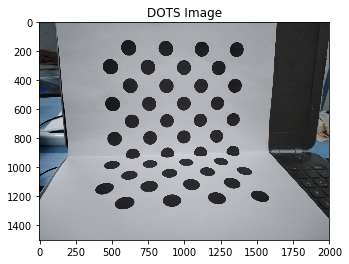

In [57]:
img_dot = cv2.imread('./Assignment1_Data/IMG_DOTS.jpg')
plt.imshow(img_dot)
plt.title("DOTS Image")
plt.show()

world_points2 = np.array([[7,5,0],[5,5,0],[3,5,0],[1,5,0],[7,3,0],[5,3,0],[3,3,0],[1,3,0],
                          [7,1,0],[5,1,0],[3,1,0],[1,1,0],[7,0,1],[5,0,1],[3,0,1],[1,0,1],
                          [7,0,3],[5,0,3],[3,0,3],[1,0,3]])

image_points2 = np.array([[490,312],[748,307],[996,310],[1238,314],[504,562],[756,560],[994,560],[1230, 558],
                        [515,802],[765,793],[1000,787],[1225,785],[500,978],[763,972],[1013,960],[1255,955],
                        [449,1140],[758,1125],[1050,1113],[1331, 1101]])


## Ques : 10 (i) DLT (on images with personal camera)

DLT Projection Matrix
[[ -1.19773197e+02  -1.25212161e+01  -5.35970900e+01   1.33393376e+03]
 [ -3.52163107e+00  -1.18866785e+02  -5.95969377e+00   8.91166913e+02]
 [ -7.74968807e-03  -1.22961805e-02  -6.71661990e-02   1.00000000e+00]]
(3, 3)

K [[ -1.64140945e+03  -4.47882889e+01   9.91430238e+02]
 [ -0.00000000e+00  -1.68582304e+03   4.00035607e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

R [[-0.99361439  0.023909    0.11026695]
 [-0.00363812 -0.98357135  0.18048312]
 [ 0.11277059  0.17892946  0.97737764]]

T [  4.55849722   6.70356739  13.13524969]

DLT Generated Image Points :
[[ 489  747  996 1237  503  754  997 1231  517  761  997 1226  502  762
  1012 1254  449  755 1049 1332]
 [ 307  310  312  315  561  559  557  555  800  795  789  784  979  970
   961  953 1140 1126 1112 1099]]


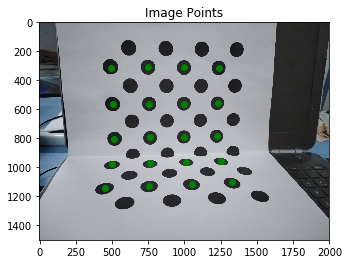

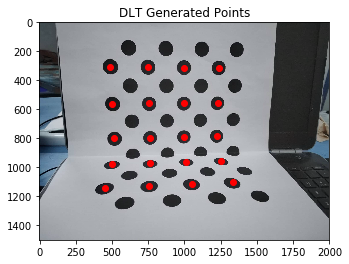

In [56]:
PROJ_DLT_my = dlt(world_points2, image_points2)
print("DLT Projection Matrix")
print(PROJ_DLT_my)
KRT_my = camera_mat(PROJ_DLT_my)
print("\nK",KRT_my[0])
print("\nR",KRT_my[1])
print("\nT",KRT_my[2])

dlt_points1 = reproduce(PROJ_DLT_my, world_points2)
print("\nDLT Generated Image Points :")
print(dlt_points1.T)

plt.title("Image Points")
plt.imshow(img_dot)
plt.plot(image_points2[:,0],image_points2[:,1],'go')
plt.show()

plt.title("DLT Generated Points")
plt.imshow(img_dot)
plt.plot(dlt_points1[:,0],dlt_points1[:,1],'ro')
plt.show()

## Ques : 10 (ii) RANSAC (on images with personal camera)

In [55]:
PROJ_RANSAC_my = ransac(image_points2, world_points2)
print("\nRANSAC Projection Matrix")
print(PROJ_RANSAC_my)
KRT_RANSAC_my = camera_mat(PROJ_RANSAC_my)
RANSAC_points_my = reproduce(PROJ_RANSAC_my, world_points2)
print("\nRANSAC Generated points")
print(RANSAC_points_my)


Iner : 1 , Max Inliers : 1
Iner : 10 , Max Inliers : 2

RANSAC Projection Matrix
[[ -1.19895570e+02  -1.23592731e+01  -5.35494846e+01   1.33195788e+03]
 [ -4.58203090e+00  -1.16733044e+02  -5.16393469e+00   8.89678793e+02]
 [ -8.48893733e-03  -1.23191151e-02  -6.71880855e-02   1.00000000e+00]]
(3, 3)

RANSAC Generated points
[[ 490  311]
 [ 748  315]
 [ 997  320]
 [1236  324]
 [ 504  561]
 [ 755  561]
 [ 997  560]
 [1230  560]
 [ 517  798]
 [ 761  793]
 [ 997  789]
 [1225  784]
 [ 502  976]
 [ 762  967]
 [1012  959]
 [1253  951]
 [ 449 1139]
 [ 756 1126]
 [1050 1113]
 [1330 1100]]


/home/parth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/parth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


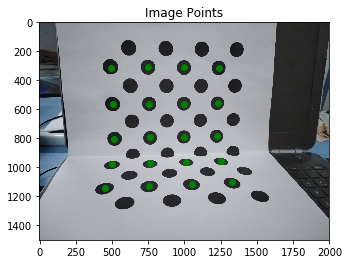

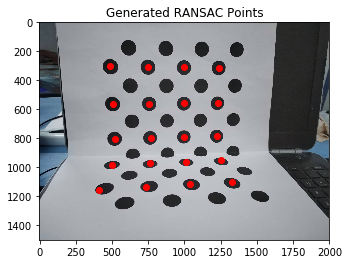

In [54]:
plt.title("Image Points")
plt.imshow(img_dot)
plt.plot(image_points2[:,0],image_points2[:,1],'go')
plt.show()

plt.title("Generated RANSAC Points")
plt.imshow(img_dot)
plt.plot(RANSAC_points_my[:,0],RANSAC_points_my[:,1],'ro')
plt.show()


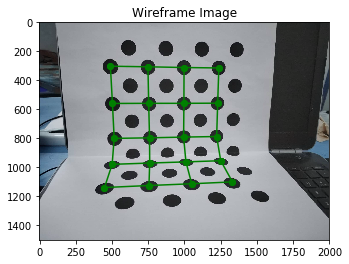

In [31]:
plt.imshow(img_dot)
plt.title("Wireframe Image")
for i in range(5):
    plt.plot(RANSAC_points_my[i*4:i*4+4,0],RANSAC_points_my[i*4:i*4+4,1],'go-')

for i in range(4):
    plt.plot([RANSAC_points_my[j*4+i,0] for j in range(5)],[RANSAC_points_my[j*4+i,1] for j in range(5)],'go-')
plt.show()

## Ques : 10 (iii) Zhangs (on images with personal camera)

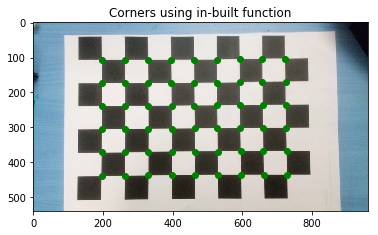

Image : 0 , ChessBoardFound : True
Image : 1 , ChessBoardFound : True
Image : 2 , ChessBoardFound : True
Image : 3 , ChessBoardFound : True
Image : 4 , ChessBoardFound : True
Image : 5 , ChessBoardFound : True


In [32]:
world_chess1 = findCorners('./Assignment1_Data/im1.jpg',[6,9])
chess_images1 = imageImport('./Assignment1_Data/im',[6,1],'.jpg')
chess_mat1 = zhangs(world_chess1,chess_images1,[6,9])

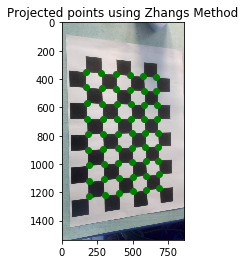

In [33]:
chess_points1 = plot_points(chess_mat1,chess_images1,world_chess1,5)

## Challenges Faced :
* Due to auto focus and inbuild features of mobile camera (dual camera) many variations were seen while Camera Calibration.
* Due to radial distortions the original points and projected points were varying in some cases.

## Learnings:
* These experiments gave a lot of insight about all these variables and helped to understand them better.
